```java
// 示例代码
package com.animal;

public class Cat {
    private int m;

    public int inc() {
        return m + 1;
    }
}
```

## 1) Magic Number & Version
---

每个Class文件的**头4个字节**被称为魔数（Magic Number），它的唯一作用是确定这个文件是否为一个能被虚拟机接受的Class文件。不仅是Class文件，很多文件格式标准中都有使用魔数来进行身份识别的习惯，譬如图片格式，如GIF或者JPEG等在文件头中都存有魔数。使用魔数而不是扩展名来进行识别主要是基于安全考虑，因为文件扩展名可以随意改动。文件格式的制定者可以自由地选择魔数值，只要这个魔数值还没有被广泛采用过而且不会引起混淆。

**紧接着魔数的4个字节**存储的是Class文件的版本号：第5和第6个字节是次版本号（Minor Version），第7和第8个字节是主版本号（Major Version）。


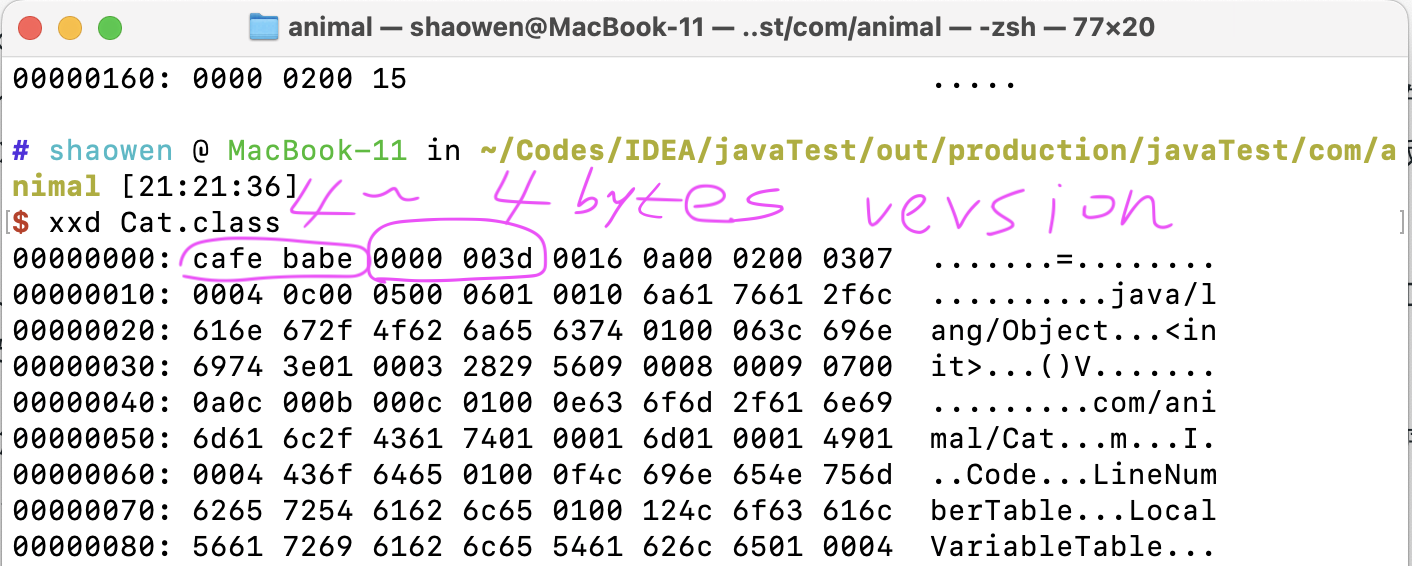

## 2) Constant Pool
----

**紧接着主、次版本号之后的是常量池入口**，常量池可以比喻为Class文件里的资源仓库，它是Class文件结构中与其他项目关联最多的数据，通常也是占用Class文件空间最大的数据项目之一。

由于常量池中常量的数量是不固定的，所以在常量池的入口需要放置一项`u2`类型的数据，代表常量池容量计数值（constant_pool_count）。与Java中语言习惯不同，这个容量计数是从1而不是0开始的，如图下所示，常量池容量（偏移地址：0x00000008）为十六进制数`0x0016`，即十进制的22，这就代表常量池中有21项常量，索引值范围为1～21。(size为22, 但是`0~21`, 然后0又被舍弃没用, 所以是`1~21`, 即21个索引) Class文件结构中只有常量池的容量计数是从1开始，对于其他集合类型，包括接口索引集合、字段表集合、方法表集合等的容量计数都与一般习惯相同，是从0开始。


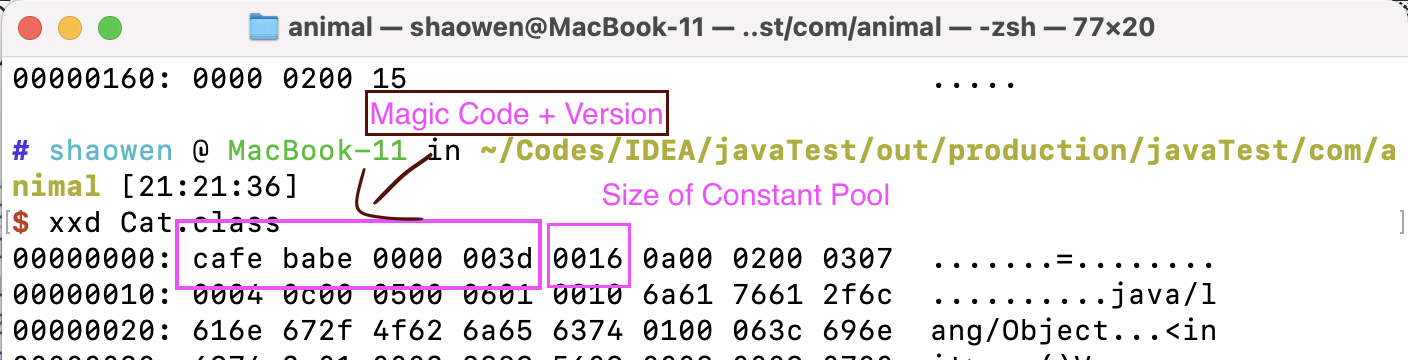

常量池中主要存放两大类常量：Literal和Symbolic References。Literal比较接近于Java语言层面的常量概念，如文本字符串、被声明为final的常量值等。而Symbolic References则属于编译原理方面的概念，主要包括下面几类常量：

- 被模块导出或者开放的包（Package）
- 类和接口的全限定名（Fully Qualified Name）
- 字段的名称和描述符（Descriptor）
- 方法的名称和描述符

Java代码在进行Javac编译的时候，并不像C和C++那样有“Linking”这一步骤，而是在虚拟机加载Class文件的时候进行动态连接（具体见第7章, 本章是第6章）。也就是说，在**Class文件中不会保存各个方法、字段最终在内存中的布局信息**，这些字段、方法的符号引用不经过虚拟机在运行期转换的话是无法得到真正的内存入口地址，也就无法直接被虚拟机使用的。当虚拟机做类加载时，将会从常量池获得对应的Symbolic References，再在类创建时或运行时解析、翻译到具体的内存地址之中。关于类的创建和动态连接的内容，在下一章介绍虚拟机类加载过程时再详细讲解。

常量池中每一项常量都是一个table，最初常量表中共有**11种结构各不相同的table**结构数据，后来为了更好地支持动态语言调用，额外增加了4种动态语言相关的常量，为了支持Java模块化系统（Jigsaw），又加入了CONSTANT_Module_info和CONSTANT_Package_info两个常量，所以截至JDK 13，常量表中分别有17种不同类型的常量。

之所以说常量池是最烦琐的数据，是因为这17种常量类型各自有着完全独立的数据结构，两两之间并没有什么共性和联系，因此只能逐项进行讲解。


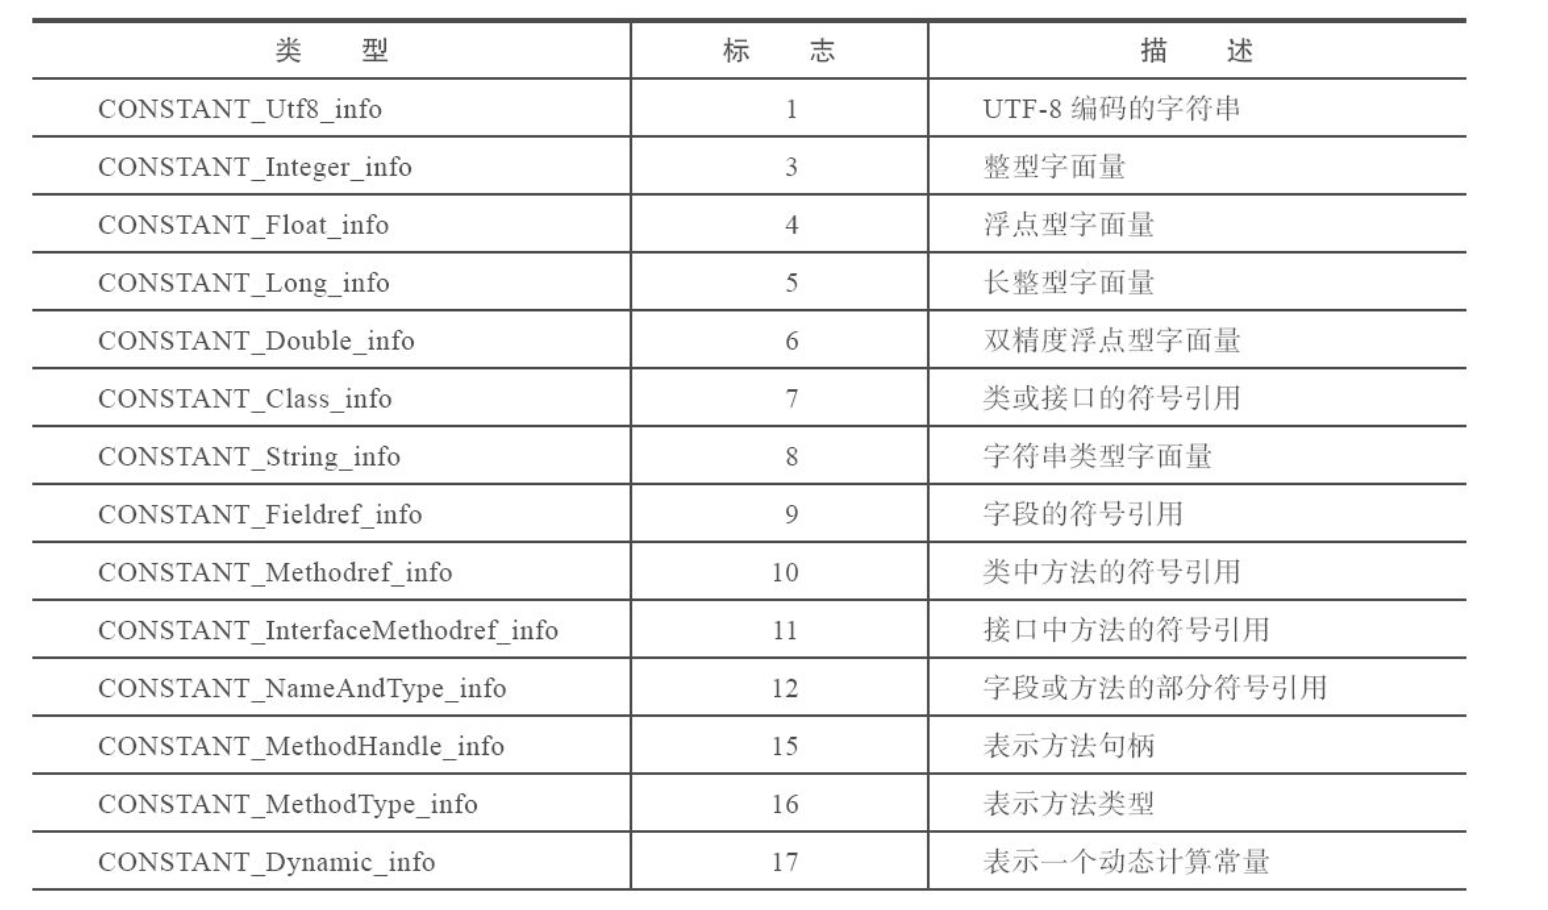

请读者回头看看上图(字节码内容的那个图)中常量池的第一项常量，它的标志位(tag)是0x0a，查表可知这个常量属于CONSTANT_Methodres_info, 看看这个数据的结构, 具体都[在Oracle官网](https://docs.oracle.com/javase/specs/jvms/se8/html/jvms-4.html):
```java
CONSTANT_Methodref_info {
    u1 tag;
    u2 class_index;
    u2 name_and_type_index;
}
```

所以根据这个结构, 因为这个数据结构的tag也就是`0x0a`占一字节, class_index占2字节, 所以我们就知道了name_and_type_index的位置以及内容:`0x0003`. 一般index的值就是告诉我们这个数据的index, index去哪找呢, 利用java的工具包输出:

```zsh
javap -verbose Cat 

Constant pool:
   #1 = Methodref          #2.#3          // java/lang/Object."<init>":()V
   #2 = Class              #4             // java/lang/Object
   #3 = NameAndType        #5:#6          // "<init>":()V
   #4 = Utf8               java/lang/Object
   #5 = Utf8               <init>
   #6 = Utf8               ()V
   #7 = Fieldref           #8.#9          // com/animal/Cat.m:I
   #8 = Class              #10            // com/animal/Cat
   #9 = NameAndType        #11:#12        // m:I
  #10 = Utf8               com/animal/Cat
  #11 = Utf8               m
  #12 = Utf8               I
  #13 = Utf8               Code
  #14 = Utf8               LineNumberTable
  #15 = Utf8               LocalVariableTable
  #16 = Utf8               this
  #17 = Utf8               Lcom/animal/Cat;
```

> 注意: The types `u1`, `u2`, and `u4` represent an unsigned one-, two-, or four-byte quantity, respectively. 查看16进制的字节码文件时, 根据数据的类型我们可以知道某个数据在哪结束, 她后面紧跟的数据在哪开始(比如1byte, 那就是两位16进制数, 所以两位16进制数之后的内容就是下一个数据了)

0x0003也就上面输出里的`#3`, 然后我们就知道了原来它的名字是`"<init>":()V`(别忘了0x0003属于name_and_type_index, 所以通过第三个entry我们就知道了这个函数的名字以及type), 然后这个数据(CONSTANT_Methodref_info)的分析就告于段落, 我们接着看下一个类型的数据, 紧接着0x0003的数据是`0x07`, 查表发现是constant_class_info, 然后再去官网看它的数据结构:

```java
CONSTANT_Class_info {
    u1 tag;
    u2 name_index;
}
```

然后name_index两字节内容紧接着tag之后`0x0004`, 所以看看上面输出的`#4`, 就发现原来这个class是`java/lang/Object`. 

以此类推, 另外查看数据的时候需注意, 如果哪个数据类型是constant_utf8_info, 然后这个类型有个属性是length, 也就是说, CONSTANT_Utf8 的数据长度由 length 决定. 

## 3) 总结
---

[请参考这个篇博客](https://juejin.cn/post/7098352303765192712)图画的很好, 截几个图放这:



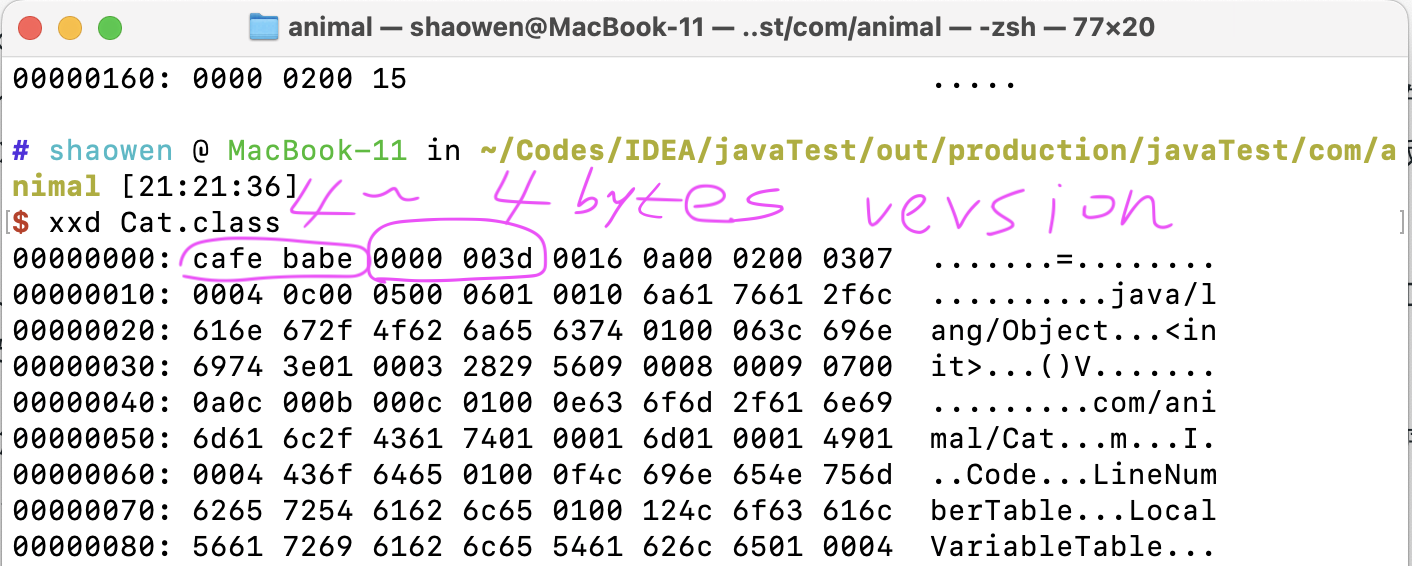

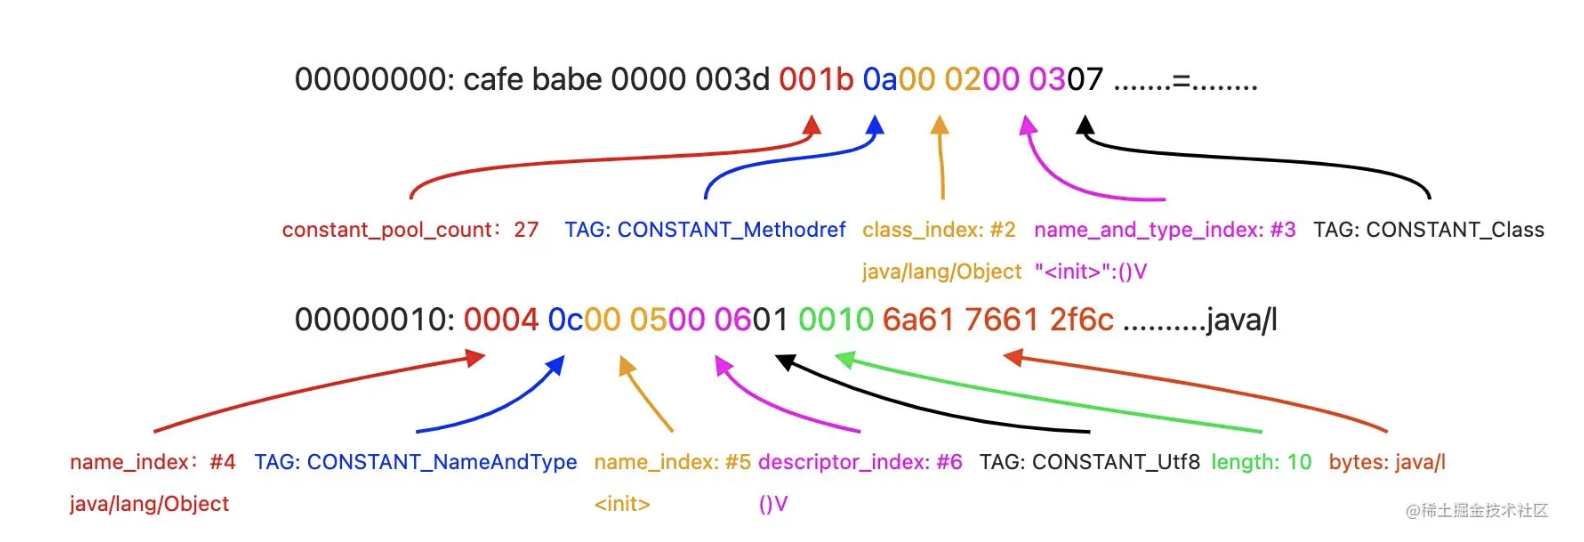